<a href="https://colab.research.google.com/github/plaban1981/Hugging_Face_transformers_topics/blob/main/Copy_of_%E2%9C%89%EF%B8%8F_MarketMail_AI_%E2%9C%89%EF%B8%8F_Fine_tuning_BLOOMZ_(Completed_Version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ⚠ IMPORTANT ⚠

Please ensure your Colab runtime is set to the following:

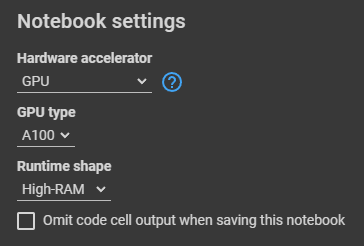

This exercise (using the sample data) will take ~40GB of GPU RAM.

# Fine-tune a BLOOMZ-based ad generation model using `peft`, `transformers` and `bitsandbytes`

This notebook should guide you through a short example of fine-tuning "structure". While this is not all that this process is capable of, it should serve to highlight some key pieces of the flow that you can extend!

Today, we'll be fine-tuning [BLOOMZ-3B](https://huggingface.co/bigscience/bloomz) a large language model trained by the BigScience team. The full paper is available [here](https://arxiv.org/abs/2211.01786)!

The general idea here is that instead of relying on the model to do zero-shot, one-shot, or few-shot in-context learning - we're going to show it many examples and let it retrain weights based off of those examples. Effectively moving the prompt-engineering piece of the puzzle into fine-tuning.

We can use the [MarketMail-AI dataset](https://huggingface.co/datasets/FourthBrainGenAI/MarketMail-AI) to fine-tune BLOOMZ to be able to generate marketing emails based off of a product and its description!

### Overview of PEFT and LoRA:

Based on some awesome new research [here](https://github.com/huggingface/peft), we can leverage techniques like PEFT and LoRA to train/fine-tune large models a lot more efficiently.

It can't be explained much better than the overview given in the above link:

```
Parameter-Efficient Fine-Tuning (PEFT) methods enable efficient adaptation of
pre-trained language models (PLMs) to various downstream applications without
fine-tuning all the model's parameters. Fine-tuning large-scale PLMs is often
prohibitively costly. In this regard, PEFT methods only fine-tune a small
number of (extra) model parameters, thereby greatly decreasing the
computational and storage costs. Recent State-of-the-Art PEFT techniques
achieve performance comparable to that of full fine-tuning.
```

### Install requirements

First, run the cells below to install the requirements:

In [ ]:
!pip install -q bitsandbytes datasets loralib
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git git+https://github.com/huggingface/accelerate.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requir

### Model loading

Let's load the `bloomz-3B` model!

We're also going to load the `bigscience/bloomz-3b` which is the tokenizer for all of the BLOOM models.

This step will take some time, as we have to download the model weights which are >6GB.

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "bigscience/bloomz-3b",
    torch_dtype=torch.float16,
    load_in_8bit=True,
    device_map='auto',
)

tokenizer = AutoTokenizer.from_pretrained("bigscience/bloomz-3b")


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('8013'), PosixPath('http'), PosixPath('//172.28.0.1')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('--logtostderr --listen_host=172.28.0.12 --

#### Model Architecture

It's important to observe the model's construction so you can ensure you know which modules you should apply LoRA to.

As per the paper, we're going to focus on the attention weights - so keep an eye out for modules like: `q_proj`, `v_proj`, `query_key_value`. This is model dependent - if you have any question - please feel free to ask!

In [ ]:
print(model)

BloomForSequenceClassification(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250880, 2560)
    (word_embeddings_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-29): 30 x BloomBlock(
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear8bitLt(in_features=2560, out_features=7680, bias=True)
          (dense): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear8bitLt(in_features=10240, out_features=2560, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((2560,), eps

### Post-processing on the model

Finally, we need to apply some post-processing on the 8-bit model to enable training, let's freeze all our layers, and cast the layer-norm in `float32` for stability. We also cast the output of the last layer in `float32` for the same reasons.

In [ ]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

### Apply LoRA

Here comes the magic with `peft`! Let's load a `PeftModel` and specify that we are going to use low-rank adapters (LoRA) using `get_peft_model` utility function from `peft`.

#### Helper Function to Print Parameter %age

This is just a helper function to print out just how much LoRA reduces the number of trainable parameters.

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

#### Initializing LoRA Config

There's a lot to unpack here - so let's talk about the main parameters:

- `r`: is the "rank" of the two decomposed matrices we'll be using to represent our weight matrix. In reality, this is the dimension of the decomposed matrices.

Here is an exerpt from the paper to help provide context for the selected `r`

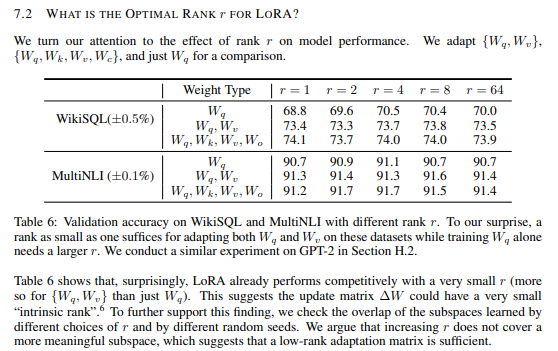


- `target_modules`: As LoRA can be applied to *any* weight matrix - we need to configure *which* module (weight matrix) it's being applied to. The paper suggests applying it to the Attention weights, and so we're doing that here. Be mindful that, while BLOOMZ's attention weight modules are called `query_key_value` - other models will name them with different convention. Please ensure you look at your model's architecture and select the appropriate module.


- `task_type`: This is a derived property. If you're using a causal model, this should be set to `CAUSAL_LM`. Please ensure this property is set based on your selected model.

Again, while this is the way we're leveraging LoRA in this notebook - it can be used in conjunction with many different models - and many different tasks. You can even use it for tasks like [token classification!](https://huggingface.co/docs/peft/task_guides/token-classification-lora)

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 4915200 || all params: 3007472640 || trainable%: 0.1634329082375293


### Preprocessing

We can simply load our dataset from 🤗 Hugging Face with the `load_dataset` method!

In [ ]:
import transformers
from datasets import load_dataset

dataset_name = "FourthBrainGenAI/MarketMail-AI"
product_name = "product"
product_desc = "description"
product_ad = "marketing_email"

In [ ]:
dataset = load_dataset(dataset_name)
print(dataset)
print(dataset['train'][0])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/17 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/FourthBrainGenAI___parquet/FourthBrainGenAI--MarketMail-AI-2490edbbc6c1c289/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['product', 'description', 'marketing_email'],
        num_rows: 17
    })
})
{'product': 'SmartEyes', 'description': 'Glasses with real-time translation', 'marketing_email': "Subject Line: 👓 Unleash Multilingual Magic with SmartEyes Glasses - See the World in YOUR Language! 🌍\n\nHey there, Language Lover! 🌟\n\nDo you dream of seamlessly navigating through conversations in any language? 🙌 Guess what! Your linguistic aspirations are about to come true with our *brand new* product - SmartEyes Glasses! 😎\n\nPicture this - you're strolling through the bustling streets of Tokyo 🇯🇵, admiring the stunning sakura blossoms. Suddenly, a friendly local strikes up a conversation. Worry not! Your SmartEyes Glasses are here to help! 🌸✨\n\nWhy choose SmartEyes, you ask? Here's the scoop: \n\n🎯 Real-time Translation: With the cutting-edge technology packed into SmartEyes Glasses, experience lightning-fast translations, making exchanges smooth and na

We want to put our data in the form:

```
### INSTRUCTION
Below is a product and description, please write a marketing email for this product.

### Product
PRODUCT NAME

### Description:
DESCRIPTION

### Marketing Email:
OUR EMAIL HERE
```

The more general idea here is that we want to show our model examples of a prompt, and its completion.

Say you were fine-tuning a Natural Language to SQL task.

In that case - the data should be moved into the following format:

```
### INSTRUCTION
Please convert the following context into an SQL query.

### CONTEXT
How many people work at my company?

### SQL
SELECT COUNT(*) FROM employees
```

Because we're using BLOOMZ (which is an instruct-tuned base model), we should see better results providing the instruction - though that is not necessary.

In [ ]:
def generate_prompt(product: str, description: str, marketing_email: str) -> str:
  prompt = f"### INSTRUCTION\nBelow is a product and description, please write a marketing email for this product.\n\n### Product:\n{product}\n### Description:\n{description}\n\n### Marketing Email:\n{marketing_email}"
  return prompt

mapped_dataset = dataset.map(lambda samples: tokenizer(generate_prompt(samples['product'], samples['description'], samples['marketing_email'])))

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

The `Trainer` class contains all the usual suspects - these are the same hyper-parameters you know and love from traditional ML applications!

If you're running into CUDA memory issues - please modify both the `per_device_train_batch_size` to be lower, and also reduce `r` in your LoRAConfig. You'll need to restart and re-run your notebook after doing so.

In [ ]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=mapped_dataset["train"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=100,
        learning_rate=1e-3,
        fp16=True,
        logging_steps=1,
        output_dir='outputs'
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Step,Training Loss
1,2.762000
2,2.784800
3,2.841400
4,2.680800
5,2.613000
6,2.783900
7,2.577100
8,2.736800
9,2.704900


## Share adapters on the 🤗 Hub

Normally, we would only seek to push the LoRA adapters to the hub. This is a lightweight and memory efficient way to push this model - as you can pull the base model down as part of the inference pipeline.

However, if you want to leverage the one-click-deploy features of Hugging Face, you'll need to first `merge_and_unload()` the model and push the resulting model to the hub. This process will merge the LoRA weights back into the base model.

Please note that if you leveraged `bitsandbytes` to load the model in 8-bit - you cannot merge the weights into the base model at this step.

In [ ]:
HUGGING_FACE_USER_NAME = "YOUR USERNAME HERE"

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

If you run into issues during upload - please ensure you're using a HF Token with `WRITE` access!

In [ ]:
model_name = "YOUR MODEL NAME HERE"

model.push_to_hub(f"{HUGGING_FACE_USER_NAME}/{model_name}", use_auth_token=True)

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.bin:   0%|          | 0.00/19.7M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/FourthBrainGenAI/BLOOMZ-3b-marketmail-ai/commit/dd84fbbb06c121e2f0f4412e49a0c2afd1b2b476', commit_message='Upload model', commit_description='', oid='dd84fbbb06c121e2f0f4412e49a0c2afd1b2b476', pr_url=None, pr_revision=None, pr_num=None)

## Load adapters from the Hub

You can also directly load adapters from the Hub using the commands below:

In [ ]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = f"{HUGGING_FACE_USER_NAME}/{model_name}"
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=False, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_id)

## Inference

You can then directly use the trained model or the model that you have loaded from the 🤗 Hub for inference as you would do it usually in `transformers`.

### Take it for a spin!

In [ ]:
from IPython.display import display, Markdown

def make_inference(product, description):
  batch = tokenizer(f"### INSTRUCTION\nBelow is a product and description, please write a marketing email for this product.\n\n### Product:\n{product}\n### Description:\n{description}\n\n### Marketing Email:\n", return_tensors='pt')

  with torch.cuda.amp.autocast():
    output_tokens = model.generate(**batch, max_new_tokens=200)

  display(Markdown((tokenizer.decode(output_tokens[0], skip_special_tokens=True))))

In [ ]:
your_product_name_here = "The Coolinator"
your_product_description_here = "A personal cooling device to keep you from getting overheated on a hot summer's day!"

make_inference(your_product_name_here, your_product_description_here)

### INSTRUCTION
Below is a product and description, please write a marketing email for this product.

### Product:
The Coolinator
### Description:
A personal cooling device to keep you from getting overheated on a hot summer's day!

### Marketing Email:
Subject Line: 🌞🌞💥 Go HOT with The Coolinator - Your Ultimate Cooling Journey! 🌬🌊

Hey there, Cool Minded Friend! 🌊🌊

Do you ever feel like your head just swings off on a hot day? Do you wish you could cool down your body and your brain right there and then? For those who love to exercise, the Coolinator is the perfect gadget to keep you cool and motivated! 💪💪

Introducing the Coolinator - your personal cooling device that helps you stay as cool as a breeze! 💦💦

🌟 Unleash your inner Steve Jobs and introduce the Coolinator to your friends and family so they too can cool off! 🌬🌊

🌟 Head to the gym, the park, or just about anywhere else your body needs a cool breather! 🌬�